<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/THRISS/03_example_pointcloud_from_stereo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example - Pointcloud from Aligned Stereo

In this example you will see how we can take two aligned stereo images and create pointcloud from them.

In [1]:
import sympy as sp
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import display

## Visualizing PointCloud data

To see if the generated poincloud makes sense we should be able to display. We can nicely visualize pointcloud data using plotly. We can also make the points colored.

In [2]:
from typing import Optional
import plotly.graph_objects as go


# code taken from: https://github.com/cvg/Hierarchical-Localization/blob/master/hloc/utils/viz_3d.py


def init_figure(height: int = 800) -> go.Figure:
    """Initialize a 3D figure."""
    fig = go.Figure()
    axes = dict(
        visible=False,
        showbackground=False,
        showgrid=False,
        showline=False,
        showticklabels=True,
        autorange=True,
    )
    fig.update_layout(
        template="plotly_dark",
        height=height,
        scene_camera=dict(
            eye=dict(x=0., y=-.1, z=-2),
            up=dict(x=0, y=-1., z=0),
            projection=dict(type="orthographic")),
        scene=dict(
            xaxis=axes,
            yaxis=axes,
            zaxis=axes,
            aspectmode='data',
            dragmode='orbit',
        ),
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.1
        ),
    )
    return fig


def plot_points(
        fig: go.Figure,
        pts: np.ndarray,
        color: str = 'rgba(255, 0, 0, 1)',
        ps: int = 2,
        colorscale: Optional[str] = None,
        name: Optional[str] = None):
    """Plot a set of 3D points."""
    x, y, z = pts.T
    tr = go.Scatter3d(
        x=x, y=y, z=z, mode='markers', name=name, legendgroup=name,
        marker=dict(
            size=ps, color=color, line_width=0.0, colorscale=colorscale))
    fig.add_trace(tr)


def plot_interactive_pointcloud(xyz, rgb):
  # plots a plotly pointcloud
  # params:
  # xyz - n x 3 - array with 3D coordinates of points
  # rgb - n x 3 - array with RGB triplets in 0-255
  fig = init_figure()
  plot_points(fig, xyz, color=rgb)
  fig.show()

## Generating 3D Pointcloud from Stereo

In this example we will use two stereo images to obtain a pointcloud. In the code below you can see how we can obtain a disparity map. Note that we do have to convert the map to float and then divide it by 16 to get meaningful results (You may ask why, the answer is - OpenCV).

After getting the diparity map we generate points in the real-world coordinates. The distance between the camera centers is 5cm. We use this information to generate triplets (X, Y, Z). Note that the X, Y in these triplets are not the same as image coordinates. We skip points with disparity -1 as this indicates that there was no match. Also do not include points with 0 disparity. We also make sure extract the rgb triplets so your pointcloud has colors.

In [3]:
!wget https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/cv08_img1.jpg
!wget https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/cv08_img2.jpg

--2024-06-11 14:27:21--  https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/cv08_img1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57221 (56K) [image/jpeg]
Saving to: ‘cv08_img1.jpg’

cv08_img1.jpg       100%[===================>]  55.88K  --.-KB/s    in 0.01s   

2024-06-11 14:27:21 (4.21 MB/s) - ‘cv08_img1.jpg’ saved [57221/57221]

--2024-06-11 14:27:22--  https://raw.githubusercontent.com/kocurvik/edu/master/3DV/labs/resources/cv08_img2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57583 (56K)

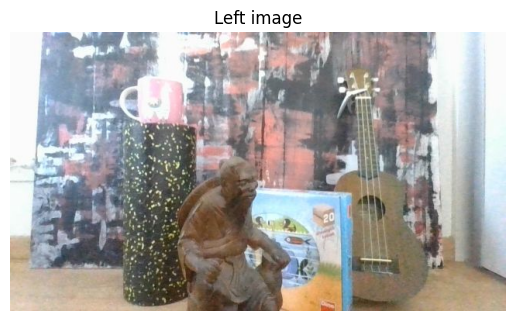

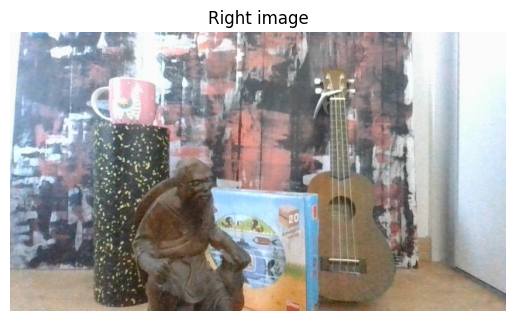

In [4]:
img_r = cv2.imread('cv08_img1.jpg')
img_l = cv2.imread('cv08_img2.jpg')

plt.imshow(img_l[:, :, ::-1])
plt.axis("off")
plt.title("Left image")
plt.show()
plt.imshow(img_r[:, :, ::-1])
plt.axis("off")
plt.title("Right image")
plt.show()


gt_K = np.array([[380, 0, 320.5], [0, 380, 180.5], [0,0,1]])

## Settings for Block Matching

We can see that the settings we use for block matching significantly impact the quality of the disparity map. Increasing the window size creates a more connected disparity map, but may miss details.

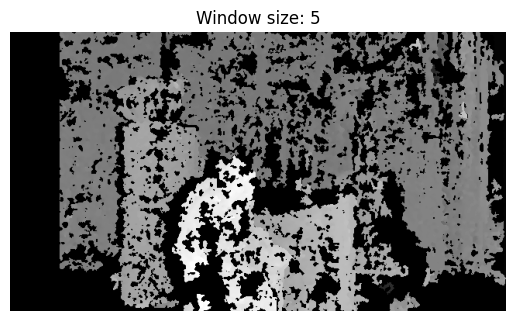

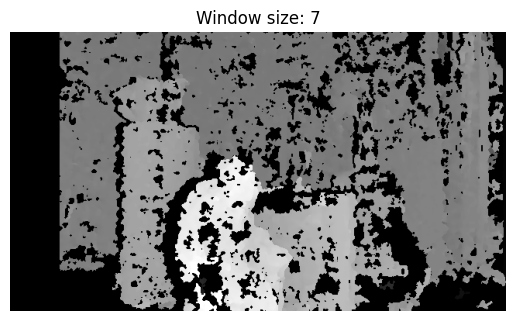

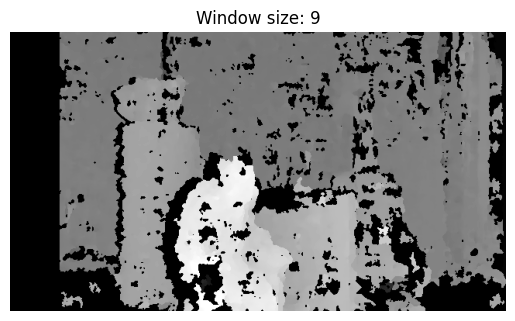

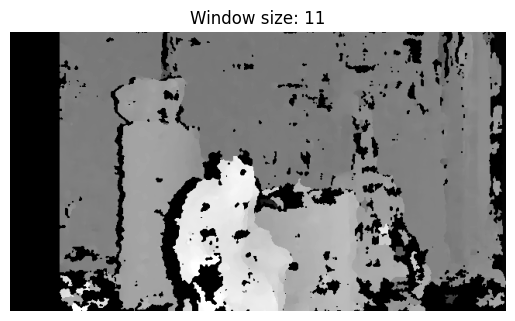

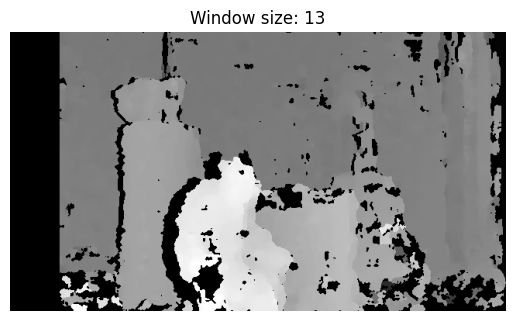

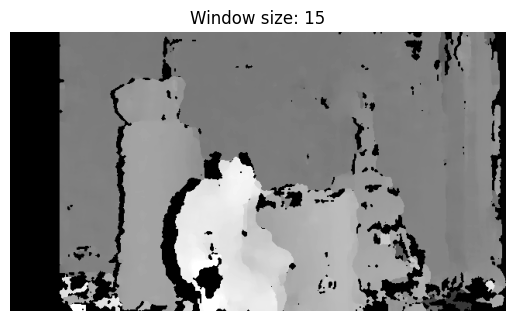

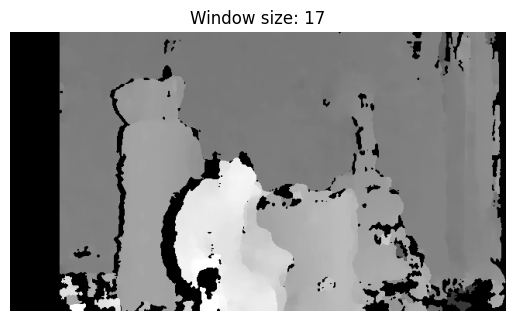

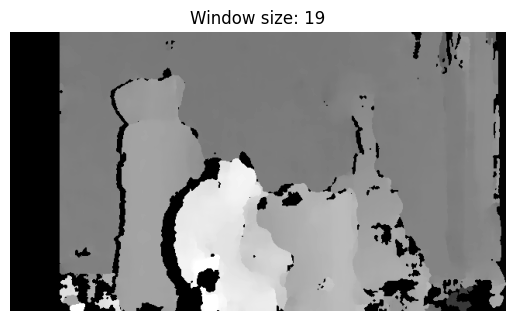

In [5]:
for win in range(5, 21, 2):
  matcher = cv2.StereoSGBM.create(0, 64, win, speckleWindowSize=100, speckleRange=1, mode=cv2.StereoSGBM_MODE_HH)
  disparity = matcher.compute(cv2.cvtColor(img_l, cv2.COLOR_RGB2GRAY),cv2.cvtColor(img_r, cv2.COLOR_RGB2GRAY)).astype(np.float32) / 16.0
  plt.imshow(disparity, cmap='gray')
  plt.title(f"Window size: {win}")
  plt.axis("off")
  plt.show()

In [7]:
# our baseline is 5cm = 0.05m
Z = 0.05 * gt_K[0, 0] / (disparity + 1e-8)
y, x = np.mgrid[:img_l.shape[0], :img_l.shape[1]]
pts = np.column_stack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))])

# we calculate the 3D coordinates

unproj_pts = (np.linalg.inv(gt_K) @ pts.T).T
pts_3d = Z.ravel()[:, np.newaxis] * unproj_pts
colors = img_l.reshape(-1, 3)[:, ::-1]

pts_3d = pts_3d[disparity.ravel() > 0]
colors = colors[disparity.ravel() > 0]

print(pts_3d.shape)
print(colors.shape)

# we plot only every 20th point so we do not generate a large file when saving the notebook

pts_3d = pts_3d[::50]
colors = colors[::50]

# we make sure that we plot only the points near the cameras so we can see them in the visualization

plot_interactive_pointcloud(pts_3d[pts_3d[:, 2] < 2], colors[pts_3d[:, 2] < 2])

(188242, 3)
(188242, 3)
